In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from os.path import join
import xarray as xr

import time
import copy 
import datetime

import sys  
sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

In [3]:
xar = xr.open_dataset(vol + '2020/sgpsondewnpnC1.b1.20200704.232600.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

In [4]:
xar

<xarray.Dataset>
Dimensions:      (time: 5018)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-04T23:26:00 ... 2020-07-05T00:49:37
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    pres         (time) float32 974.76 973.5 972.79 971.94 ... 15.76 15.75 15.75
    qc_pres      (time) int32 ...
    tdry         (time) float32 34.0 34.01 33.77 33.58 ... -44.51 -44.5 -44.49
    qc_tdry      (time) int32 ...
    dp           (time) float32 18.95 18.38 18.28 18.29 ... -84.24 -84.23 -84.23
    qc_dp        (time) int32 ...
    wspd         (time) float32 ...
    qc_wspd      (time) int32 ...
    deg          (time) float32 ...
    qc_deg       (time) int32 ...
    rh           (time) float32 ...
    qc_rh        (time) int32 ...
    u_wind       (time) float32 ...
    qc_u_wind    (time) int32 ...
    v_wind       (time) float32 ...
    qc_v_wind    (time) int32 ...
    wstat        (time) float32 ...
    asc          (time) float32 ...
    qc_asc       (time) int32 ...
    lat          (time) float32 ...
    lon          (time) float32 ...
    alt          (time) float32 ...
Attributes:
    command_line:               sonde_ingest -s sgp -f C1
    Conventions:                ARM-1.2
    process_version:            ingest-sonde-10.13-0.el7
    dod_version:                sondewnpn-b1-2.2
    input_source:               /data/collection/sgp/sgpsondeC1.00/good.2020J...
    site_id:                    sgp
    platform_id:                sondewnpn
    facility_id:                C1
    data_level:                 b1
    location_description:       Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:                 sgpsondewnpnC1.b1
    sample_int:                 1.2 seconds
    averaging_int:              None
    serial_number:              R0830817
    ingest_software:            ingest-sonde-10.13-0.el7
    resolution_description:     The resolution field attributes refer to the ...
    pressure_correction:        1.1
    temperature_correction:     -9999.0
    humidity_correction:        -9999.0
    humidity_correction_2:      -9999.0
    launch_mode:                nominal mode
    launch_status:              
\n/// SGPC1/MW41
\n474646
\n200704 2326
\n R...
    pressure_gc_sonde:          973.6
    temperature_gc_sonde:       -9999.0
    humidity_gc_sonde:          -9999.0
    humidity_gc_sonde_2:        -9999.0
    latitude_calculation:       lat[k-1]+((v_wind[k]-v_wind[k-1])/2)*delta_ti...
    longitude_calculation:      lon[k-1]+((u_wind[k]-u_wind[k-1])/2)*delta_ti...
    sonde_pc_software_version:  2.40
    sounding_number:            ///
    doi:                        10.5439/1595321
    history:                    created by user dsmgr on machine zinc at 2020...

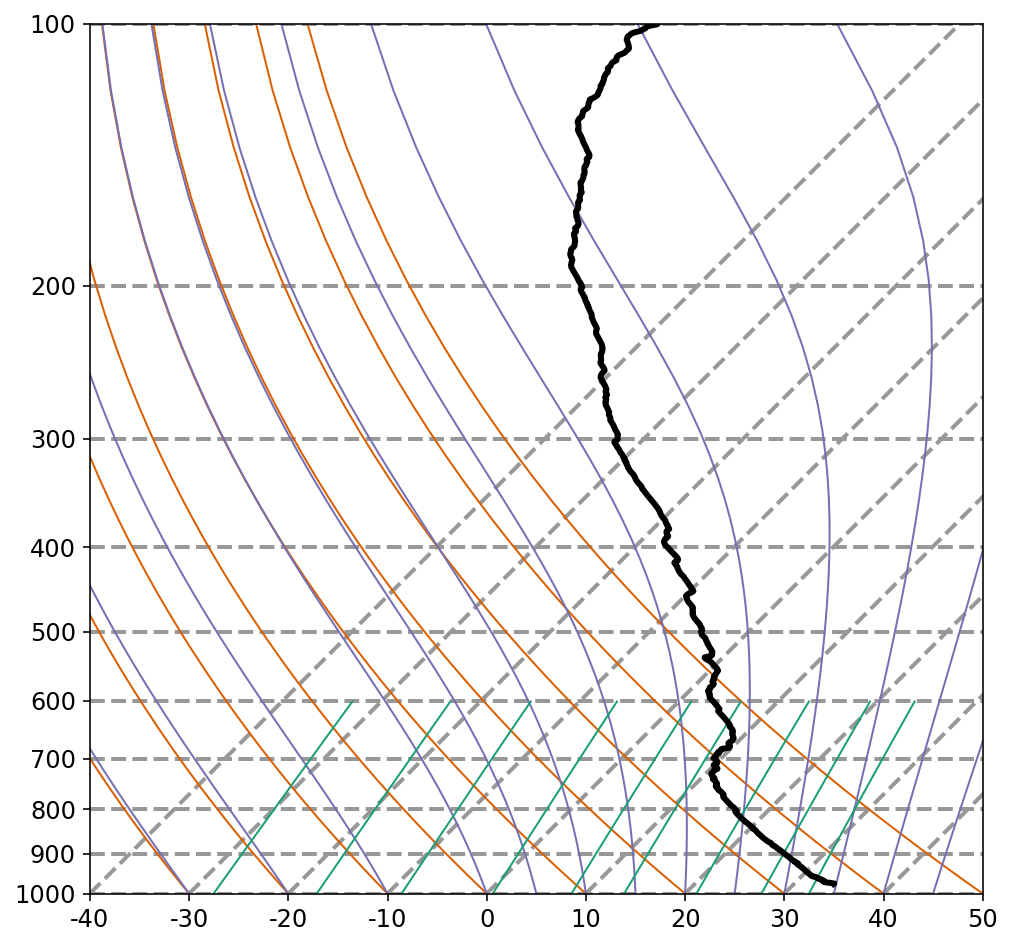

In [6]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [41]:
a = np.expand_dims(np.random.randint(0, 10, (2, 5)), axis=0)
b = np.expand_dims(np.random.randint(0, 10, (2, 5)), axis=0)
np.concatenate((a, b)).shape

(2, 2, 5)

In [7]:
SONDE_PROFILE_DIMS = 2000
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= SONDE_PROFILE_DIMS and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

time: 13.420, avg: 0.013 seconds
2001: 874/1037 are valid


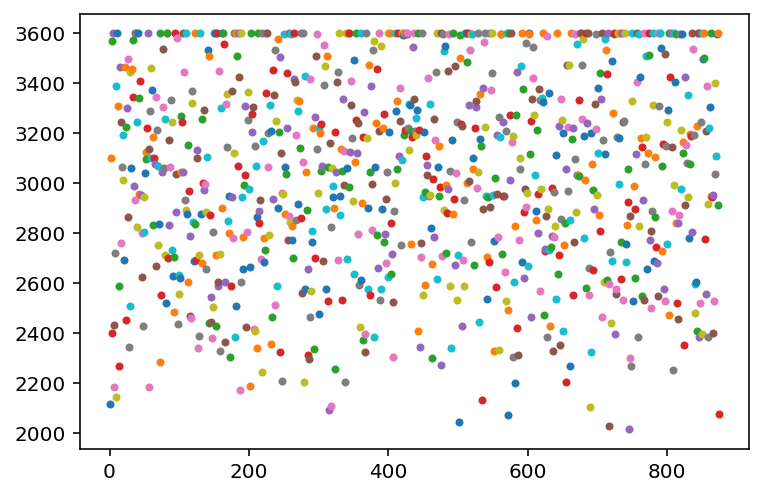

In [9]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(valid, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [8]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

time: 508.811, avg: 0.019 seconds
: 24589/27209 are valid


In [9]:
profiles.shape

(24589, 3, 2000)

In [62]:
len(Xtest.shape)

2

In [69]:
def plot_results(nnet, X, T, index=0):
    fig, ax = plt.subplots(1, figsize=(8, 4))

    ax.plot(nnet.history['loss'], label='train')
    ax.plot(nnet.history['val_loss'], label='val')
    ax.legend();

    sounding_dict_for_metpy = dict()

    if len(X.shape) > 2:
        P = X[index,:,PRESSURE]
    else:
        P = X[index,:SONDE_PROFILE_DIMS]

    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]

    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)

## Fully Connected NN

In [54]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [55]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21083
epoch: 5, loss: 0.08327
epoch: 10, loss: 0.07642
epoch: 15, loss: 0.06756
epoch: 20, loss: 0.06361
epoch: 24, loss: 0.06004
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06004 in 176.8057 seconds.

In [56]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

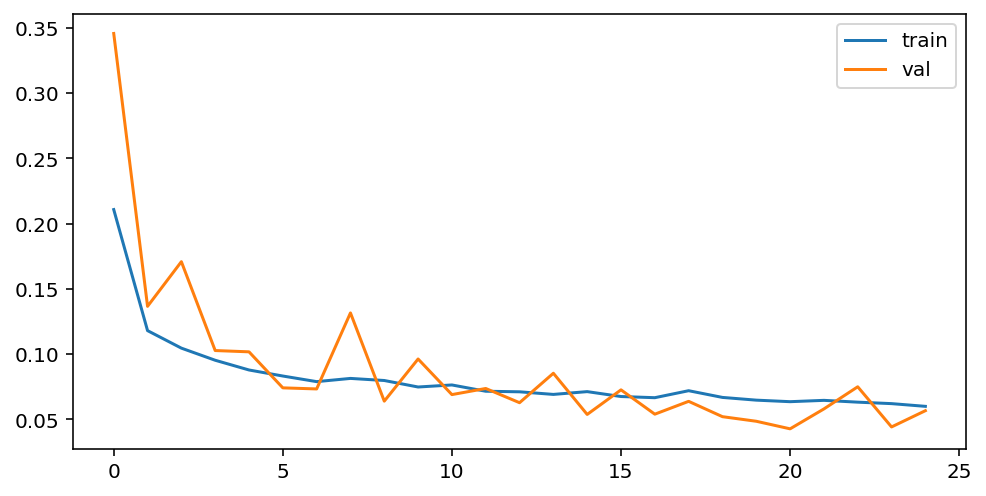

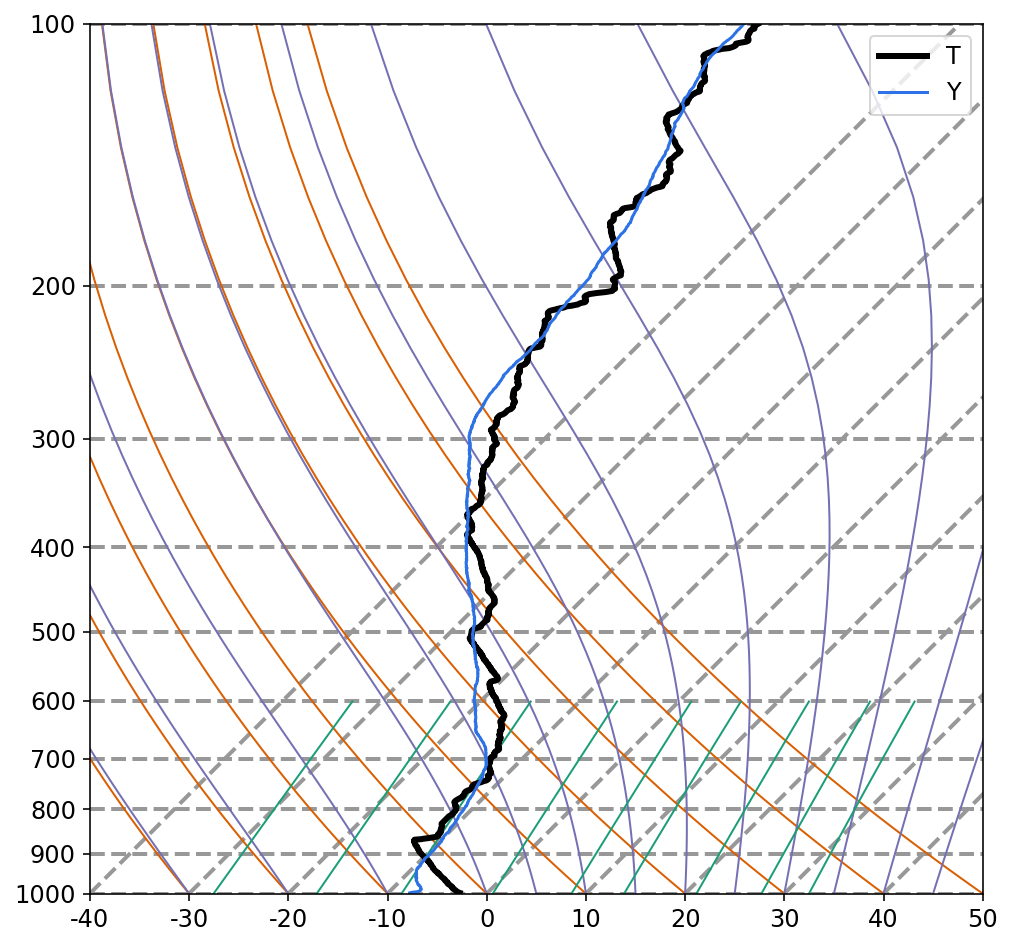

In [71]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional NN

In [41]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [42]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 10, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.38233
epoch: 5, loss: 0.00688
epoch: 9, loss: 0.00413
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00413 in 82.3424 seconds.

In [43]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 3)           93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 3)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 3)           93        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 3)            93        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 3)            0     

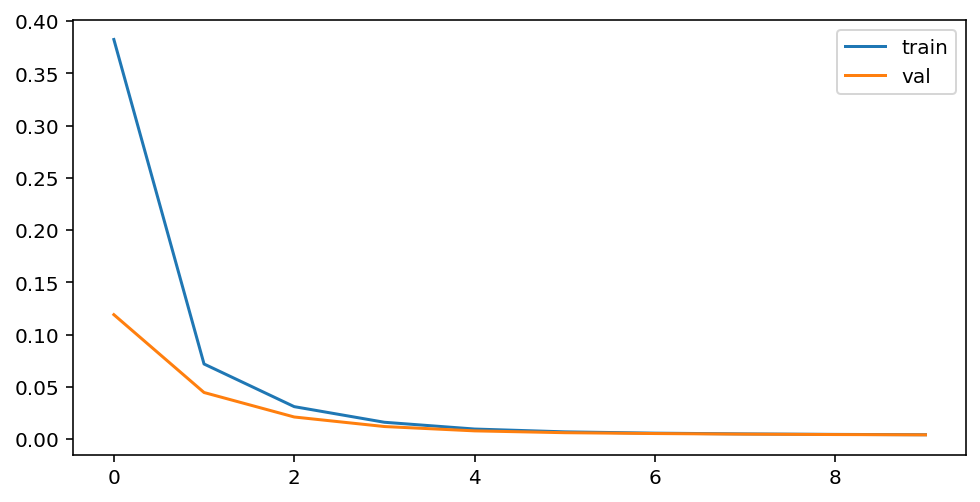

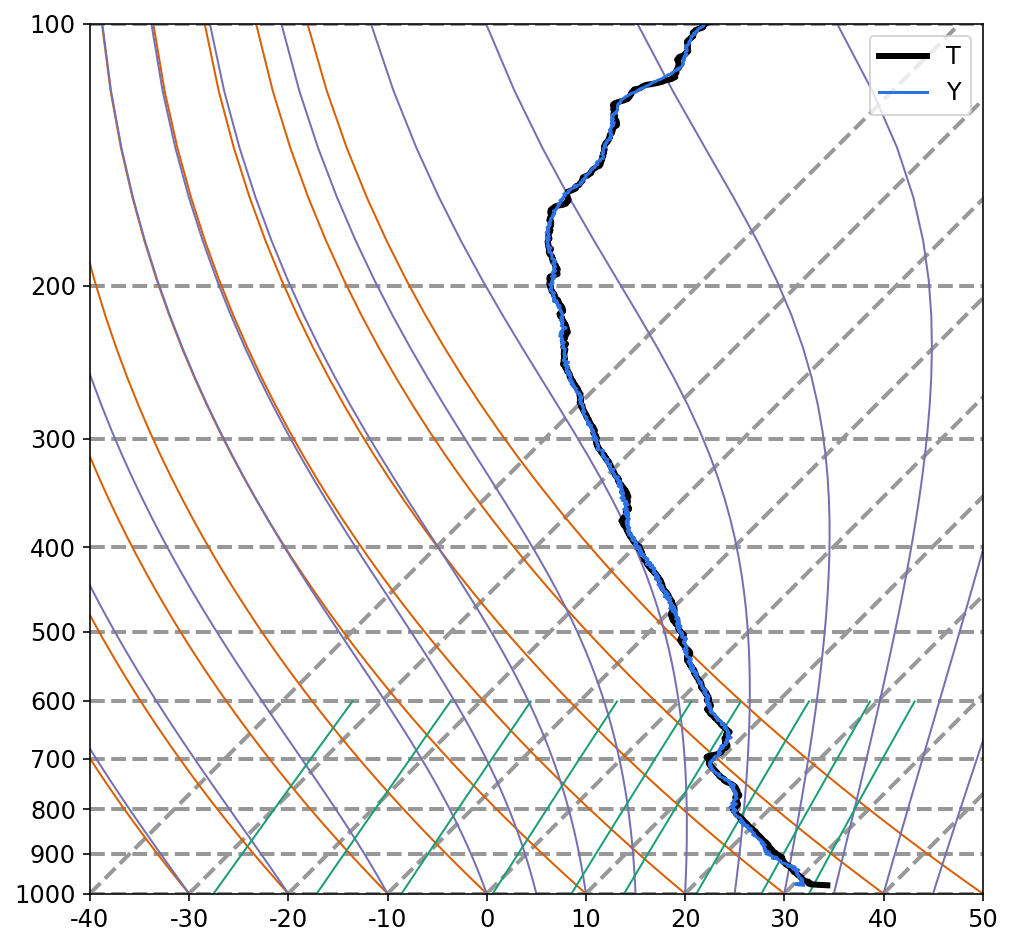

In [53]:
plot_results(nnet, Xtest, Ttest, index=0)

## Convolutional AutoEncoder

In [72]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [73]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], (8, 16, 24), [(10, 1)]*3,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 15, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.64830
epoch: 5, loss: 0.58896
epoch: 10, loss: 0.58886
epoch: 14, loss: 0.58883
finished!


ConvolutionalAutoEncoder((2000, 3), (8, 16, 24), [(10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.58883 in 443.3226 seconds.

In [74]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 8)           248       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 16)          1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 24)           3864      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 24)           0     

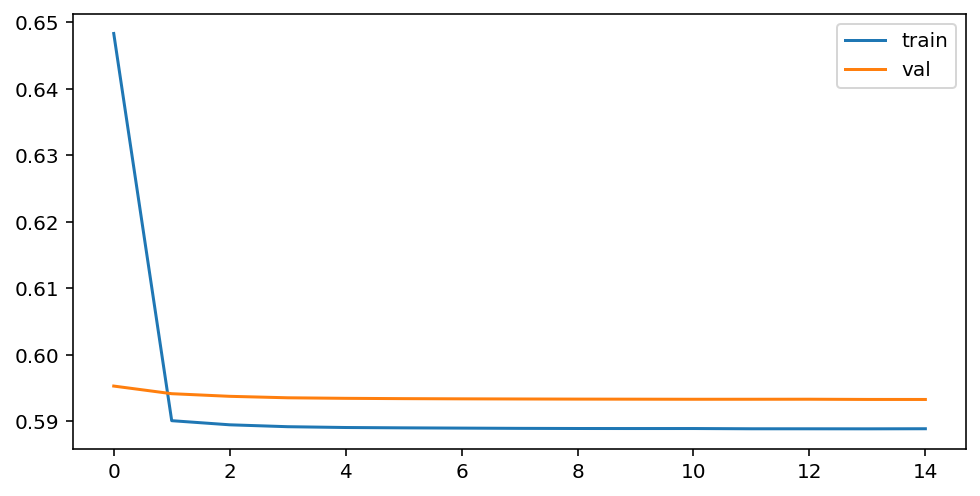

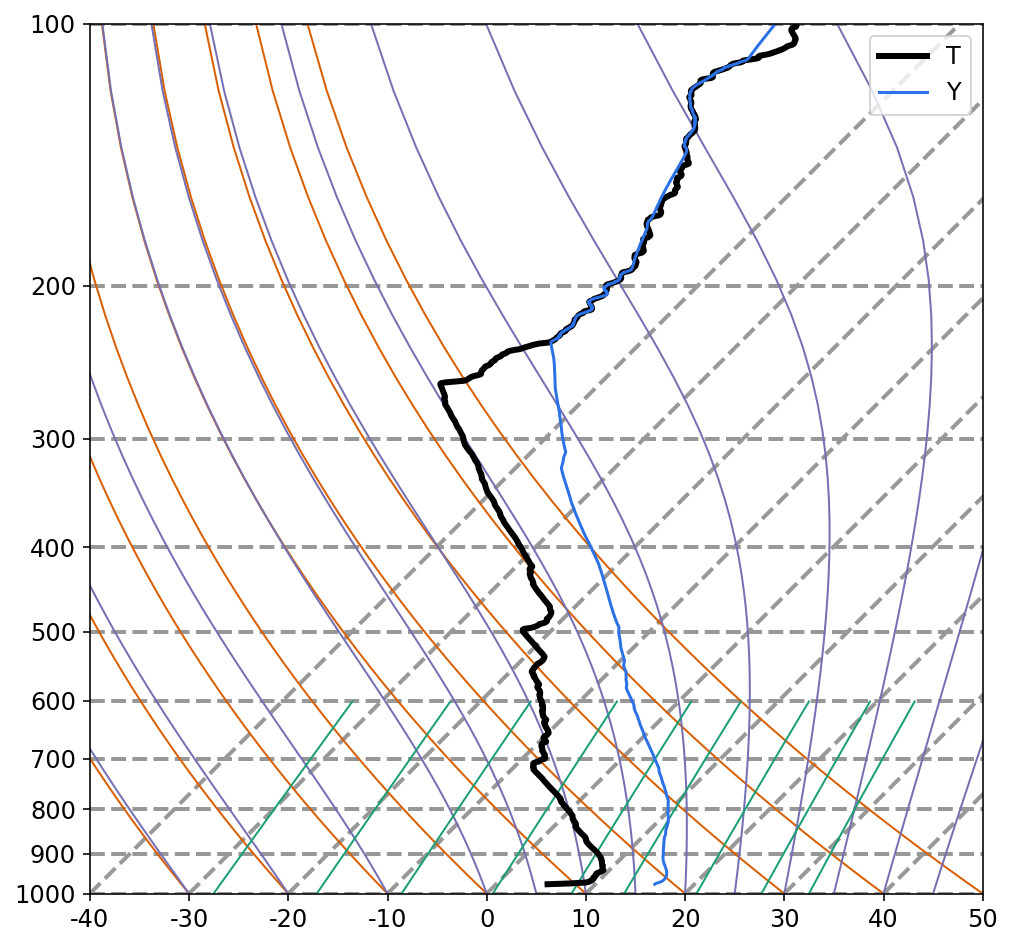

In [76]:
plot_results(nnet, Xtest, Ttest, index=1)

## Operational

In [77]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i8:  926.0 B
                          _i24:  815.0 B
                          _i27:  810.0 B
                          _i29:  807.0 B
                          _i30:  807.0 B
                          _i32:  798.0 B
